In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

from tqdm import trange
from numpy.testing import assert_allclose

import sys

sys.path.insert(0, "./scripts")

from scripts.swe_2d import ShallowTwo, ShallowTwoFilter
from statfenics.utils import build_observation_operator

fe.set_log_level(50)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
mesh = "./mesh/branson.xdmf"
params = {"nu": 1e-5, "C": 0., "H": 0.053, "u_inflow": 0.004, "inflow_period": 120}
control = {"dt": 5e-2,
           "theta": 0.5,
           "simulation": "cylinder",
           "use_imex": False,
           "use_les": False}
swe = ShallowTwoFilter(mesh, params, control)
assert swe.L == 2.
assert swe.B == 1.

# check that all the dofs line up
assert_allclose(np.unique(swe.W.dofmap().dofs()),
                np.unique(np.concatenate((swe.u_dofs,
                                          swe.v_dofs,
                                          swe.h_dofs))))
swe.setup_form()
swe.setup_solver()

(114, 2)


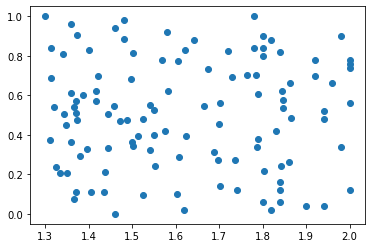

In [3]:
data_file = "data/run-8-synthetic-data.h5"

with h5py.File(data_file, "r") as f:
    t_data = f["t"][:]
    x_data = f["x"][:]
    u_data = f["u"][:]
    v_data = f["v"][:]
    
mask_obs = x_data[:, 0] >= 1.3
x_obs = x_data[mask_obs, :][::20]
print(x_obs.shape)

plt.plot(x_obs[:, 0], x_obs[:, 1], "o")
Hu = build_observation_operator(x_obs, swe.W, sub=(0, 0))
Hv = build_observation_operator(x_obs, swe.W, sub=(0, 1))

In [4]:
from scipy.sparse import vstack

H = vstack((Hu, Hv))
print(H.shape)

(228, 87530)


In [5]:
# setup filter (basically compute prior additive noise covariance)
rho = 1e-2
ell = 0.5
stat_params = dict(rho_u=rho, rho_v=rho, rho_h=0.,
                   ell_u=ell, ell_v=ell, ell_h=0.5,
                   k_init_u=32, k_init_v=32, k_init_h=16, k=32,
                   sigma_y=2e-4, H=H)
swe.setup_filter(stat_params)

# as on the same fcn space
assert_allclose(swe.Ku_vals, swe.Kv_vals)

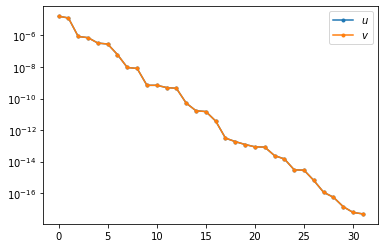

In [6]:
plt.semilogy(swe.Ku_vals, ".-", label="$u$")
plt.semilogy(swe.Kv_vals, ".-", label="$v$")
plt.legend()
plt.show()

In [7]:
t = 0.
t_final = 30.
nt = np.int32(np.round(t_final / control["dt"]))

i_dat = 0
for i in trange(nt):
    t += swe.dt
    swe.inlet_velocity.t = t
    swe.prediction_step(t)
    
    if i % 2 == 0:
        assert np.isclose(t_data[i_dat], t)
        y_obs = np.concatenate((u_data[i_dat, mask_obs][::20], 
                                v_data[i_dat, mask_obs][::20]))
        swe.update_step(y_obs, compute_lml=False)
        i_dat += 1
        
    swe.set_prev()

 46%|████████████████████████████████▋                                      | 276/600 [40:02<47:00,  8.70s/it]


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with PETScSNESSolver.
*** Reason:  Solver did not converge.
*** Where:   This error was encountered inside PETScSNESSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  ba376b6aebd7a9bc089be46b50bdd9f5c548fb91
*** -------------------------------------------------------------------------


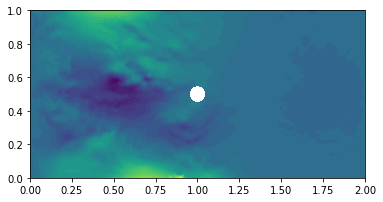

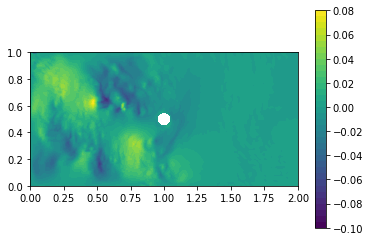

In [8]:
vel, h = swe.du.split()
u, v = vel.split()

fe.plot(u)
plt.show()

im = fe.plot(v)
plt.colorbar(im)
plt.show()

In [ ]:
fe.parameters["num_threads"] = 8